In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

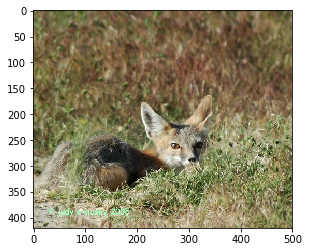

In [4]:
# load test image

from PIL import Image
import torchvision.transforms.functional as TF

test_image = Image.open('testimage.jpg')
plt.imshow(test_image)
plt.show()

In [6]:
#create transformation
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],
                         std = [ 0.229, 0.224, 0.225 ]),
])

In [7]:
# try out on test image
# note that the image looks weird due to the normalization

transformed_image = transform(test_image)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(test_image)
ax2.imshow(transformed_image.permute(1, 2, 0))
plt.savefig("preprocessing.png")

In [36]:
data = torchvision.datasets.ImageFolder(root="./cats_dogs", transform=transform)
trainset, testset = torch.utils.data.random_split(data, [int(len(data) - len(data)/5), int( len(data)/5 )])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=4)

In [37]:
def get_pad_layer(pad_type):
    if(pad_type in ['refl','reflect']):
        PadLayer = nn.ReflectionPad2d
    elif(pad_type in ['repl','replicate']):
        PadLayer = nn.ReplicationPad2d
    elif(pad_type=='zero'):
        PadLayer = nn.ZeroPad2d
    else:
        print('Pad type [%s] not recognized'%pad_type)
    return PadLayer

class BlurPool(nn.Module):
    def __init__(self, pad_type='reflect', filter_size=2, stride=2, channels=None, pad_off=0):
        super(BlurPool, self).__init__()
        self.filter_size = filter_size
        self.pad_off = pad_off
        self.pad_sizes = [int(1.*(filter_size-1)/2), int(np.ceil(1.*(filter_size-1)/2)), int(1.*(filter_size-1)/2), int(np.ceil(1.*(filter_size-1)/2))]
        self.channels = channels
        self.pad_sizes = [pad_size+pad_off for pad_size in self.pad_sizes]
        self.stride = stride
        self.off = int((self.stride-1)/2.)
        
        if(self.filter_size==1):
            a = np.array([1.,])
        elif(self.filter_size==2):
            a = np.array([1., 1.])
        elif(self.filter_size==3):
            a = np.array([1., 2., 1.])
        elif(self.filter_size==4):    
            a = np.array([1., 3., 3., 1.])
        elif(self.filter_size==5):    
            a = np.array([1., 4., 6., 4., 1.])
        elif(self.filter_size==6):    
            a = np.array([1., 5., 10., 10., 5., 1.])
        elif(self.filter_size==7):    
            a = np.array([1., 6., 15., 20., 15., 6., 1.])
        
        filt = torch.Tensor(a[:,None]*a[None,:])
        filt = filt/torch.sum(filt)
        self.register_buffer('filt', filt[None,None,:,:].repeat((self.channels,1,1,1)))
        
        self.pad = get_pad_layer(pad_type)(self.pad_sizes)
    
    def forward(self, inp):
        if(self.filter_size==1):
            if(self.pad_off==0):
                return inp[:,:,::self.stride,::self.stride]    
            else:
                return self.pad(inp)[:,:,::self.stride,::self.stride]
        else:
            return F.conv2d(self.pad(inp), self.filt, stride=self.stride, groups=inp.shape[1])
        

In [38]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [39]:
class AlexNetNMP(nn.Module):

    def __init__(self, num_classes=2, filter_size=3):
        super(AlexNetNMP, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            BlurPool(filter_size=filter_size, stride=2, channels=64, pad_off=-1),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            BlurPool(filter_size=filter_size, stride=2, channels=192, pad_off=-1),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            BlurPool(filter_size=filter_size, stride=2, channels=256, pad_off=-1),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [53]:
net = AlexNetNMP()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.02, momentum=0.9)
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
print('Finished Training')

[1,   100] loss: 0.662
[1,   200] loss: 0.643
[1,   300] loss: 0.643
[1,   400] loss: 0.635
[1,   500] loss: 0.624
[1,   600] loss: 0.609
[2,   100] loss: 0.605
[2,   200] loss: 0.611
[2,   300] loss: 0.590
[2,   400] loss: 0.595
[2,   500] loss: 0.573
[2,   600] loss: 0.560
Finished Training


In [54]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = (data[0].to(device), data[1].to(device))
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the x test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the x test images: 70 %
